In [1]:
import os
from typing import Tuple, List
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# constants
DATA_DIR: str = "data/tumor_mri"
TRAIN_DIR: str = os.path.join(DATA_DIR, "Training")
TEST_DIR: str = os.path.join(DATA_DIR, "Testing")
IMG_SIZE: Tuple[int, int] = (150, 150)
BATCH_SIZE: int = 32
VALID_SPLIT: float = 0.2
EPOCHS: int = 20
CLASS_NAMES: List[str] = ["glioma", "meningioma", "notumor", "pituitary"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES: int = len(CLASS_NAMES)


In [2]:
def create_data_loaders(train_dir: str,
                        test_dir: str,
                        img_size: Tuple[int, int],
                        batch_size: int,
                        valid_split: float
                        ) -> Tuple[DataLoader, DataLoader, DataLoader]:
    tfms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    full_train = datasets.ImageFolder(train_dir, transform=tfms)
    val_size = int(len(full_train) * valid_split)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])
    test_ds = datasets.ImageFolder(test_dir, transform=tfms)
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=batch_size),
        DataLoader(test_ds, batch_size=batch_size)
    )

train_loader, val_loader, test_loader = create_data_loaders(
    TRAIN_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE, VALID_SPLIT
)


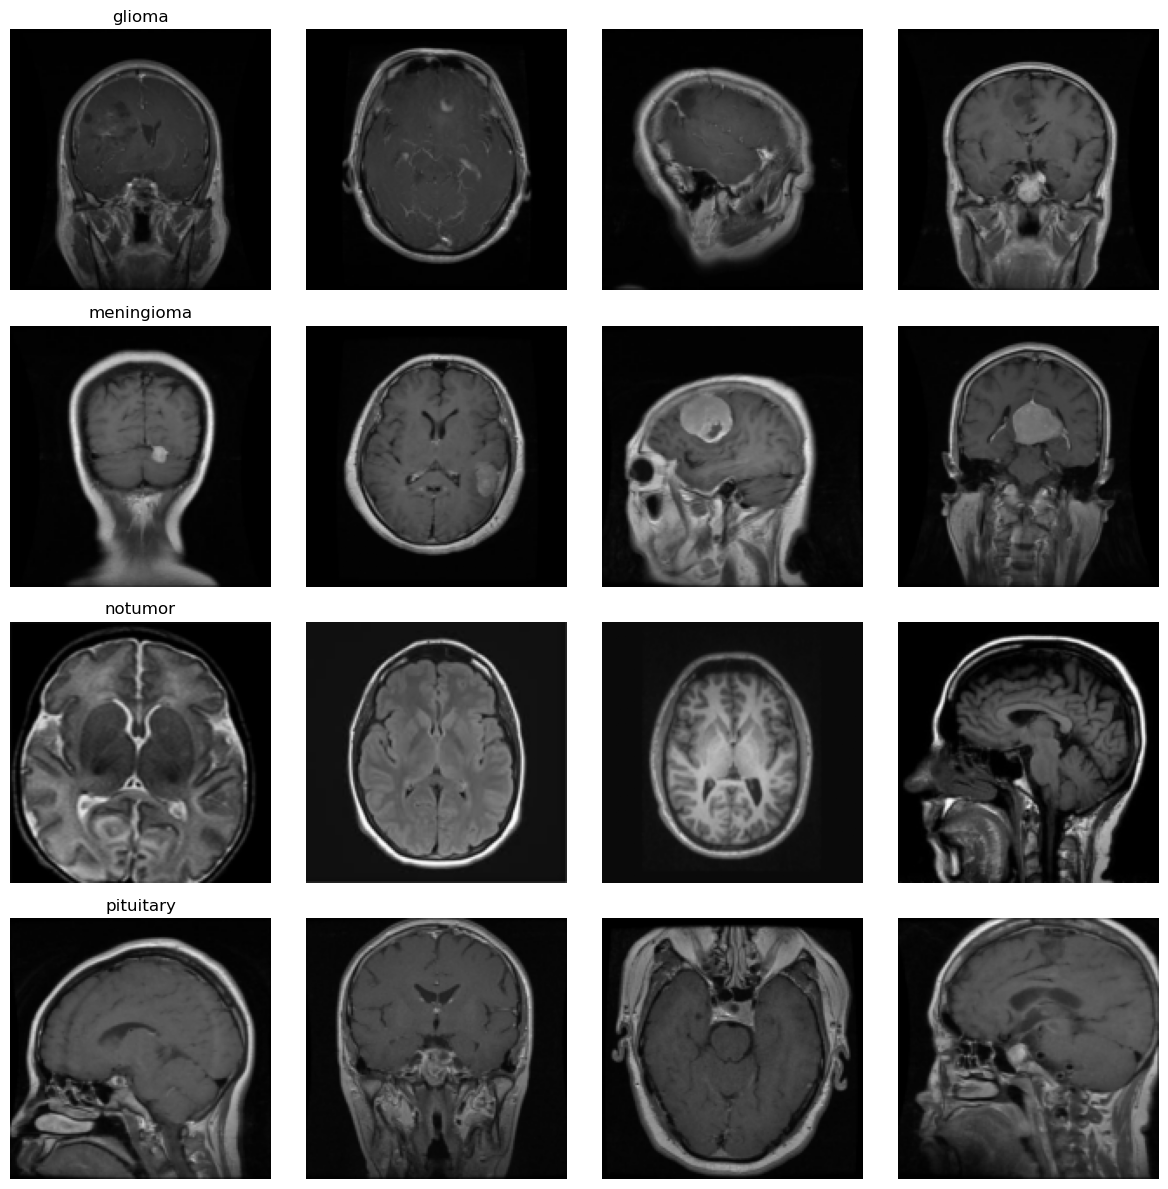

In [ ]:
def get_class_samples(loader: DataLoader,
                      class_names: List[str],
                      samples_per_class: int
                      ) -> dict[str, List[torch.Tensor]]:
    samples = {c: [] for c in class_names}
    for imgs, labels in loader:
        for img, lbl in zip(imgs, labels):
            name = class_names[lbl]
            if len(samples[name]) < samples_per_class:
                samples[name].append(img)
        if all(len(v) >= samples_per_class for v in samples.values()):
            break
    return samples

def show_grid(samples: dict[str, List[torch.Tensor]], cols: int = 4) -> None:
    graphic_size = 1
    rows = len(samples)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*graphic_size, rows*graphic_size))
    for i, (cls, imgs) in enumerate(samples.items()):
        for j in range(cols):
            ax = axes[i, j]
            ax.imshow(imgs[j].permute(1,2,0))
            ax.axis("off")
            if j == 0:
                ax.set_title(cls)
    plt.tight_layout()
    plt.show()

train_samples = get_class_samples(train_loader, CLASS_NAMES, 4)
show_grid(train_samples)

# test_samples = get_class_samples(test_loader, CLASS_NAMES, 4)
# show_grid(test_samples)


In [ ]:
class TumorCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE[0]//8) * (IMG_SIZE[1]//8), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.features(x))

model = TumorCNN(NUM_CLASSES).to(DEVICE)
print(model)
